# PyMC3 proxy intro

## Standard imports

First, set up some standard modules and matplotlib.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
from regressproxy.models_pymc3 import ProxyModel

## Proxy interface

We create a mock proxy time series to resemble something that might be used to fit time series data.
In the "real" world this may be some kind of index, for example Kp or Ap for geophysical data,
or some economic parameter.

In [4]:
# x is actually the modified Julian day number for the year 2000
xs = 51544.5 + np.arange(0., 1 * 365. + 2, 1.)
ys = np.zeros_like(xs)
ys[20::60] = 1

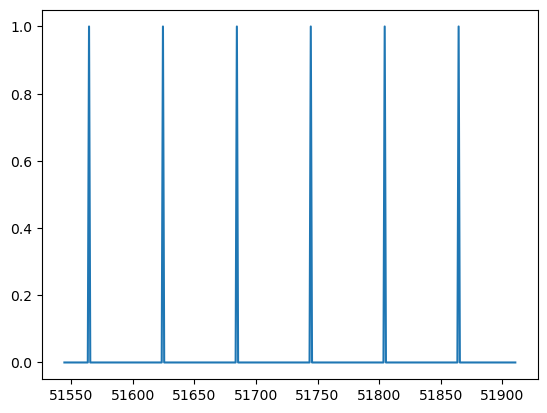

In [5]:
plt.plot(xs, ys)

We use the very peaked time series to setup the proxy model.
In this case it can be seen as isolated events happening at certain times,
here with a fixed amplitude for demonstration.
The `ProxyModel` modifies the original proxy by including a finite decaying lifetime and a lag.
We start with a fixed lag of 2 days and a constant lifetime of 5 days.
The lifetime can be made variable, up to now including annual and semi-annual variations (see below).

In [6]:
proxy = ProxyModel(
    xs,
    ys,
    amp=1,
    lag=2,
    tau0=5,
    tau_scan=30,
    days_per_time_unit=1.,
)

According to the parameters, the peaks will be shifted by 2 time units (days) to the right,
and the finite lifetime "dilutes" the peaked proxy values in time.
A similar thing happens if after some event, the specific effect related to that event
persists for some time, which can be different from persistence of an overall effect like
in an autoregressive model.

In [7]:
p0 = proxy.get_value(xs).eval()

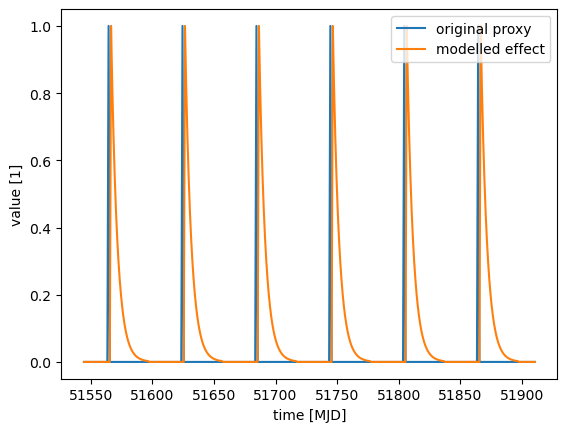

In [8]:
plt.plot(xs, ys, label="original proxy")
plt.plot(xs, p0, label="modelled effect")
plt.xlabel("time [MJD]")
plt.ylabel("value [1]")
plt.legend();

## Model parameters

### Using a PyMC3 model

(Almost) every parameter can be sampled from a `pymc3` distribution.

In [9]:
RANDOM_SEED = 92354

In [10]:
import pymc3 as pm

In [11]:
with pm.Model() as model1:
    amp = pm.Normal("amp", sigma=2.)
    lag = pm.HalfNormal("lag", sigma=2.)
    tau0 = pm.HalfNormal("tau0", sigma=4.)
    
    proxy1 = ProxyModel(
        xs,
        ys,
        amp,
        lag=lag,
        tau0=tau0,
        tau_scan=30,
        days_per_time_unit=1.,
    )
    pm.Deterministic("proxy", proxy1.get_value(xs))

Technically there is no need to include the `amp` parameter,
the same can be achieved by multiplying the result by the same factor.

With the model `model1` set up this way, we can evaluate it at a point by calling
`model.<var>.eval(<point>)`.
Here we are interested in the "proxy" deterministic variable containing the lagged and
decaying proxy.

In [12]:
p1 = model1.proxy.eval({model1["amp"]: 1, model1["lag"]: 2, model1["tau0"]: 5})

With the same input we should get the same output:

In [13]:
np.testing.assert_allclose(p1, p0)

### Prior predictive sampling

We can also take samples from the prior predictive distribution.

In [14]:
with model1:
    pred1 = pm.sample_prior_predictive(samples=3, random_seed=RANDOM_SEED)

In [15]:
pred1["amp"][:1]

array([1.9858651])

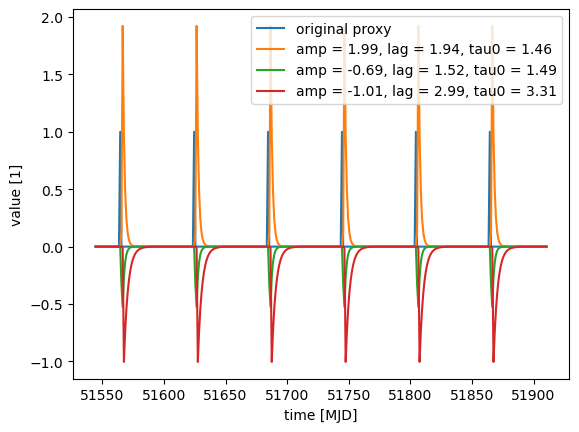

In [16]:
plt.plot(xs, ys, label="original proxy")
for i, p in enumerate(pred1["proxy"]):
    plt.plot(
        xs, p,
        label=f"amp = {pred1['amp'][i]:.2f}, lag = {pred1['lag'][i]:.2f}, tau0 = {pred1['tau0'][i]:.2f}"
    )
plt.xlabel("time [MJD]")
plt.ylabel("value [1]")
plt.legend();

### Variable life time

The same works when we want the lifetime to be variable.

In [17]:
from regressproxy.models_pymc3 import HarmonicModelCosineSine, LifetimeModel

In [18]:
freqs = [1, 2]
nfreqs = len(freqs)

In [19]:
with pm.Model() as model2:
    amp = pm.Normal("amp", sigma=2.)
    lag = pm.HalfNormal("lag", sigma=2.)
    tau0 = pm.HalfNormal("tau0", sigma=2.)
    tau_cos = pm.Normal("tau_cos", sigma=6., shape=(nfreqs,))
    tau_sin = pm.Normal("tau_sin", sigma=2., shape=(nfreqs,))
    tau_harms = [
        HarmonicModelCosineSine(f / 365.25, tau_cos[i], tau_sin[i])
        for i, f in enumerate(freqs)
    ]
    tau_lt = LifetimeModel(tau_harms, lower=0.)

    proxy2 = ProxyModel(
        xs,
        ys,
        amp,
        lag=lag,
        tau0=tau0,
        tau_scan=30,
        tau_harm=tau_lt,
        days_per_time_unit=1.,
    )
    # keep also track of the harmonic part and the lifetime.
    pm.Deterministic("harmonics", pm.math.stack([_h.get_value(xs) for _h in tau_harms]))
    pm.Deterministic("lifetime", tau0 + tau_lt.get_value(xs))
    pm.Deterministic("proxy", proxy2.get_value(xs))

In [20]:
with model2:
    pred2 = pm.sample_prior_predictive(samples=3, random_seed=RANDOM_SEED)

In [21]:
# adjust numpy print options
np_printopts = np.get_printoptions()
np.set_printoptions(precision=1)

In [22]:
def sample_label_all(i):
    return (
        f"amp = {pred2['amp'][i]:.1f}, "
        f"lag = {pred2['lag'][i]:.1f}, "
        f"tau0 = {pred2['tau0'][i]:.1f}, "
        f"cos = {pred2['tau_cos'][i]}, "
        f"sin = {pred2['tau_sin'][i]}"
    )

Text(0.5, 1.0, 'proxy')

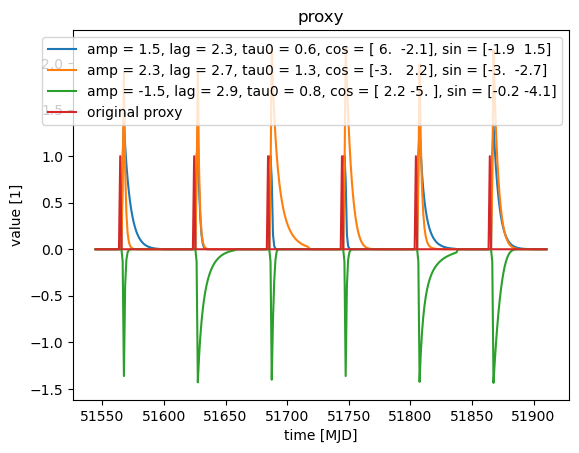

In [23]:
for i, p in enumerate(pred2["proxy"]):
    plt.plot(
        xs, p,
        label=sample_label_all(i)
    )
plt.plot(xs, ys, label="original proxy")
plt.xlabel("time [MJD]")
plt.ylabel("value [1]")
plt.legend()
plt.title("proxy")

In [24]:
def sample_label_lt(i):
    return (
        f"tau0 = {pred2['tau0'][i]:.1f}, "
        f"cos = {pred2['tau_cos'][i]}, "
        f"sin = {pred2['tau_sin'][i]}"
    )

Since we kept track of them, we can also have a look at the harmonic and lifetime part separately:

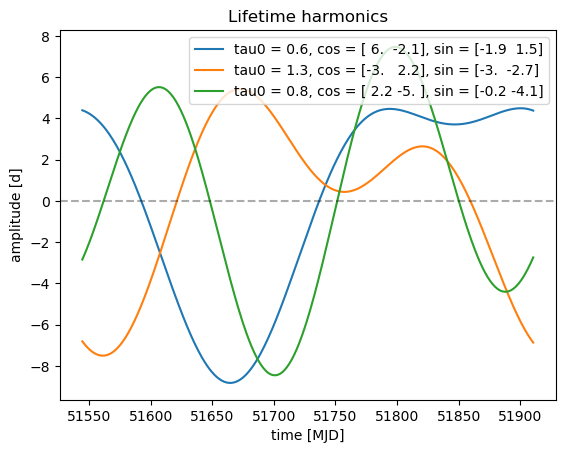

In [25]:
for i, p in enumerate(pred2["harmonics"]):
    plt.plot(
        xs, p.sum(axis=0),
        label=sample_label_lt(i),
    )
plt.axhline(0., color="k", alpha=0.33, ls="--")
plt.title("Lifetime harmonics")
plt.xlabel("time [MJD]")
plt.ylabel("amplitude [d]")
plt.legend();

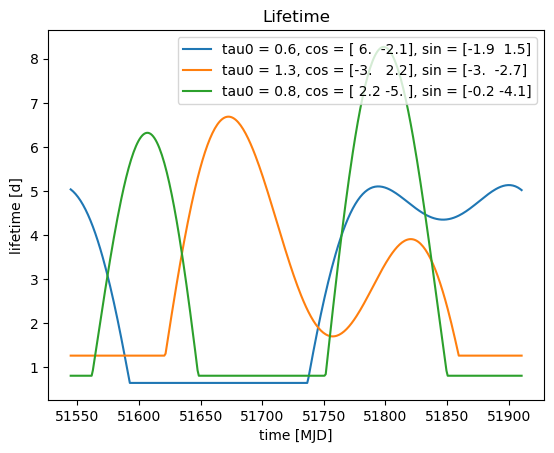

In [26]:
for i, p in enumerate(pred2["lifetime"]):
    plt.plot(
        xs, p,
        label=sample_label_lt(i)
    )
plt.title("Lifetime")
plt.xlabel("time [MJD]")
plt.ylabel("lifetime [d]")
plt.legend();

In [27]:
# reset numpy print options
np.set_printoptions(**np_printopts)